In [ ]:
from IPython.display import clear_output

In [ ]:

# Download the required libraries (needed when running outside colab where the environment doesn't come pre-loaded with libraries)

%pip install torch
%pip install torchvision
%pip install matplotlib

clear_output()

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision.datasets import MNIST
from torchvision.transforms.functional import to_tensor, to_pil_image, resize
from torchvision import transforms

from torch.utils.data import DataLoader
from torch.optim import Adam

import matplotlib.pyplot as plt

# Sign Langauge Problem:

## Intution: The AI is so powrful and important because of its various applications on most if not all the different fields. As a result, we want to help in solving the issue of not understanding sign languages.

## - This notebook contains a detailed implementaiton of a NN uisng Pytorch.

### 1. Data set Details:

- The provided data set is ArASL (Arabic Alphabets Sign Language Dataset). It is as its name says, an arabic sighn langauge for Arabic alphabet. It has a total of 54049 images and their corrssponding labels.

### 2. Size of data:
- Length of train_dataset is 43239,
- Length of val_dataset is 10810

### 3. Labels representations:
- Each sample has a label, which can be one of the 32 classes.
It consist of 32 classes for the alphabet.
- The classes values are integers from 0 up to 31.


### 4. The mapping details:

- Each number represents a charcter. You can see the dictionary in the variable "mapping".

<br/>
-- You can see the mapping in the following:

0: 'seen', 1: 'zay', 2: 'aleff', 3: 'dal', 4: 'ta', 5: 'yaa', 6: 'fa', 7: 'ya', 8: 'khaa', 9: 'nun', 10: 'ha', 11: 'toot', 12: 'taa', 13: 'ra', 14: 'kaaf', 15: 'jeem', 16: 'laam', 17: 'la', 18: 'dhad', 19: 'dha', 20: 'waw', 21: 'meem', 22: 'al', 23: 'sheen', 24: 'haa', 25: 'thaa', 26: 'saad', 27: 'ghain', 28: 'ain', 29: 'thal', 30: 'gaaf', 31: 'bb'

### 5. Refrence:
Latif, G., Mohammad, N., Alghazo, J., AlKhalaf, R., & AlKhalaf, R. (2019). ARASL: Arabic Alphabets Sign Language Dataset. *Data in Brief*, 23, 103777. https://doi.org/10.1016/j.dib.2019.103777

## Downloading the dataset

### Run the following cells to download the MNIST dataset.

In [ ]:
!gdown https://data.mendeley.com/public-files/datasets/y7pckrw6z2/files/1efa0d6b-4d7f-4f58-9584-08f0488279ee/file_downloaded

Downloading...
From: https://data.mendeley.com/public-files/datasets/y7pckrw6z2/files/1efa0d6b-4d7f-4f58-9584-08f0488279ee/file_downloaded
To: /content/file_downloaded
100% 66.2M/66.2M [00:02<00:00, 22.9MB/s]


In [ ]:
!unzip file_downloaded
clear_output()

## Just run these two cells. You are not supposed to explore them.

In [ ]:
import os

def rename_folders_and_create_mapping(folder_path):
    # Get the list of folders in the specified path
    folders = [folder for folder in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, folder))]

    # Create a mapping from original folder names to numbers
    folder_mapping = {folder: i for i, folder in enumerate(folders)}

    # Rename the folders in-place and store the original names in the mapping
    for original_folder, number in folder_mapping.items():
        new_folder_name = str(number)
        new_folder_path = os.path.join(folder_path, new_folder_name)

        # Rename the folder
        os.rename(os.path.join(folder_path, original_folder), new_folder_path)

    return folder_mapping

folder_path = 'ArASL_Database_54K_Final'

# Create the folder mapping and rename folders
mapping = rename_folders_and_create_mapping(folder_path)

# Print the folder mapping
print("Folder Mapping:")
print(mapping)


Folder Mapping:
{'seen': 0, 'zay': 1, 'aleff': 2, 'dal': 3, 'ta': 4, 'yaa': 5, 'fa': 6, 'ya': 7, 'khaa': 8, 'nun': 9, 'ha': 10, 'toot': 11, 'taa': 12, 'ra': 13, 'kaaf': 14, 'jeem': 15, 'laam': 16, 'la': 17, 'dhad': 18, 'dha': 19, 'waw': 20, 'meem': 21, 'al': 22, 'sheen': 23, 'haa': 24, 'thaa': 25, 'saad': 26, 'ghain': 27, 'ain': 28, 'thal': 29, 'gaaf': 30, 'bb': 31}


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os

class CustomDataset(Dataset):
    def __init__(self, root_folder, transform=None, target_size=(28, 28)):
        self.root_folder = root_folder
        self.transform = transform
        self.target_size = target_size

        # Get the list of image files
        self.image_files = []
        self.image_labels = []

        for root, dirs, files in os.walk(root_folder):
            for file in files:
                if file.lower().endswith('.jpg'):
                    self.image_files.append(os.path.join(root, file))
                    self.image_labels.append(int(os.path.basename(root)))

    def __len__(self):
        return len(self.image_labels)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        label = self.image_labels[idx]

        # Convert label to tensor
        label = torch.tensor(label)

        # Open the image
        with Image.open(img_path) as img:
            # Convert the image to grayscale
            img = img.convert('L')

            # Resize the image
            img = img.resize(self.target_size)

            # Apply additional transformations if specified
            if self.transform:
                img = self.transform(img)

            return (img, label)

# Define the root folder and output folder
root_folder_path = 'ArASL_Database_54K_Final'


# Define transformations (resize to 28x28 and convert to tensor)
data_transform = transforms.Compose([
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
])

# Create an instance of the custom dataset
custom_dataset = CustomDataset(root_folder_path, transform=data_transform)

from torch.utils.data import random_split

# Define the size of the training and validation sets
total_size = len(custom_dataset)
train_size = int(0.8 * total_size)  # 80% for training
val_size = total_size - train_size  # 20% for validation

# Split the dataset
train_dataset, val_dataset = random_split(custom_dataset, [train_size, val_size])

mapping = {v:k for k,v in mapping.items()}

## Exploring the data

#### Here is the mapping for each class and its encoding. In addition to the train_dataset and val_dataset

In [ ]:
train_dataset # Contains the training ArASL_Database_54K_Final dataset (80%)

val_dataset  # Contains the validating ArASL_Database_54K_Final dataset (20%)


print("The mapping between the letters and the encoding: \n", mapping)
print('Length of train_dataset is', len(train_dataset))
print('Length of val_dataset is'  , len(val_dataset))

The mapping between the letters and the encoding: 
 {0: 'seen', 1: 'zay', 2: 'aleff', 3: 'dal', 4: 'ta', 5: 'yaa', 6: 'fa', 7: 'ya', 8: 'khaa', 9: 'nun', 10: 'ha', 11: 'toot', 12: 'taa', 13: 'ra', 14: 'kaaf', 15: 'jeem', 16: 'laam', 17: 'la', 18: 'dhad', 19: 'dha', 20: 'waw', 21: 'meem', 22: 'al', 23: 'sheen', 24: 'haa', 25: 'thaa', 26: 'saad', 27: 'ghain', 28: 'ain', 29: 'thal', 30: 'gaaf', 31: 'bb'}
Length of train_dataset is 43239
Length of val_dataset is 10810


In [ ]:
batch_size = 64 # To group each k samples together.

# DataLoaders simplify the job of grouping the samples into batches.
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)  # no need to shuffle validation data

## Let's visualize an image and its channels

The image shape: torch.Size([1, 48, 48])
Number of channels in image:  1
The image label: 9 nun


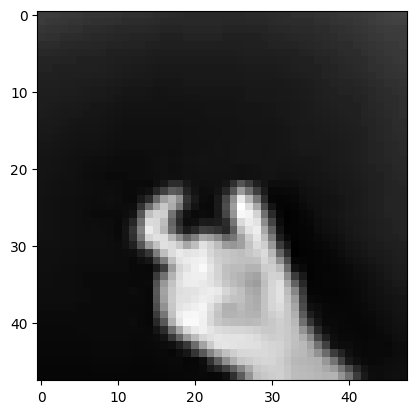

In [ ]:
random_img_idx = 30 # Write any random index (between 0 and 59999)

image = train_dataset[random_img_idx][0]  # 0 for image part in (image, label) tuple.
label = train_dataset[random_img_idx][1]  # 1 for label part

print("The image shape:", image.shape)
print('Number of channels in image: ', image.shape[0]) # 1 channel (layer) for black-white images.
print("The image label:", label.item(), mapping[label.item()])

plt.imshow(image.reshape(48, 48), cmap='gray')

### Create a loop to show 10 different images ranodmly

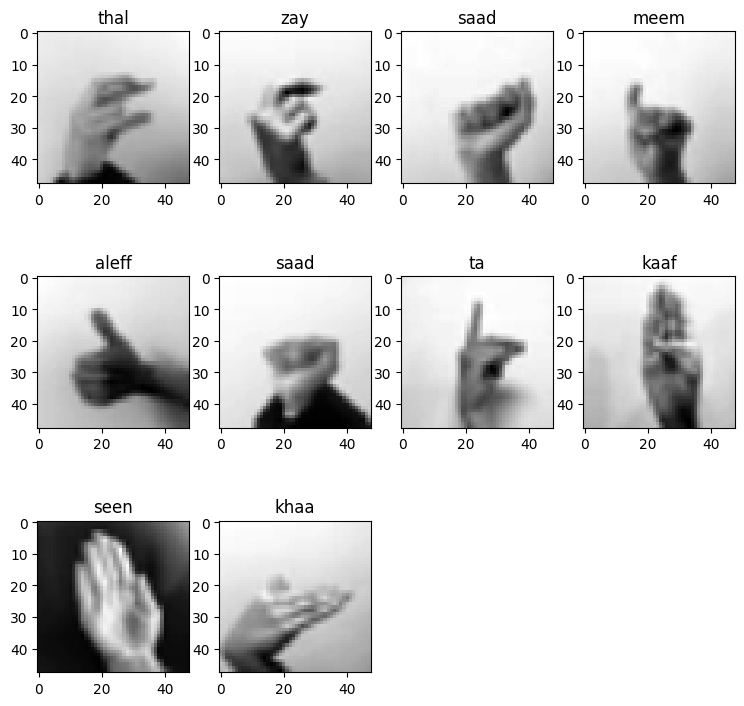

In [ ]:
import random

# create figure
fig = plt.figure(figsize=(9, 9))

for i in range(10):
    random_img_idx = random.randint(0, 43238) # Write any random index (between 0 and 43238)

    image = train_dataset[random_img_idx][0]  # 0 for image part in (image, label) tuple.
    label = train_dataset[random_img_idx][1]  # 1 for label part

    # Adds a subplot at the 2nd position
    fig.add_subplot(3, 4, i+1)
    plt.title(mapping[label.item()])
    plt.imshow(image.reshape(48, 48), cmap='gray')

### Create a NN uisng Pytorch. Play with the layers to get the best model on the validation data.

In [ ]:
import torch.nn.functional as F
class SignLangModel(nn.Module):
  def __init__(self, input_size):
    super(SignLangModel, self).__init__()


    self.linear1 = nn.Linear(input_size, 1024)
    self.linear2 = nn.Linear(1024, 512)
    self.linear3 = nn.Linear(512, 128)
    self.linear4 = nn.Linear(128, 32)


  def forward(self, x):

    x = torch.relu(self.linear1(x))
    x = torch.relu(self.linear2(x))
    x = torch.relu(self.linear3(x))
    x = self.linear4(x) # We did not put softmax here because we are using nn.CrossEntropyLoss()
                        # nn.CrossEntropyLoss() uses softmax inside it and computes it in a better techniques.

    return x

### Preparing the mdoel and the optimizer.
1. Prepare the device to move the calculations into the GPU.
2. Create the model object that you have defined previously.

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'  # checks if machine supports cuda and if it does, we use that, otherwise cpu
input_size = 48 * 48
model = SignLangModel(input_size).to(device)

#### Define whatever you need of variables before the training loop.

In [ ]:
num_epochs = 15
lr = 1e-3

train_losses = []
val_losses = []

optimizer = Adam(model.parameters(), lr=lr) # Adam is an optimizer (i.e. GD, SGD)
criterion = nn.CrossEntropyLoss()  # multi-class loss.

print(f'Using device {device}')

Using device cuda


#### Train the model and make sure to store the losses of training and validation sets somewhere for later.

1. Create one loop for learninig from the training set.
2. Wrap the training loop by a loop for multiple iterations.
3. After the training loop, add a loop specified for the validaiton set.
4. Compute the accuracy of your model for each iteration.

In [ ]:
%%time
for epoch_no in range(num_epochs):

  model.train()  # convert to train model. This turns out train-specific layers in the model (if you dont know about them, an example of them is dropout. more on this later)

  epoch_weighted_loss = 0

  for batch_X, batch_y in train_loader:

    # We need to flatten the input because it is a 2D array (image) not a linear.
    batch_X = batch_X.view(-1, 48 * 48)

    # Move everything to the device.
    batch_X = batch_X.to(device)
    batch_y = batch_y.to(device)

    # predicite over X.
    batch_y_probs = model(batch_X)  # outputs [N, 10] where each [:, 10] is probabilities for class (0-9)

    # Compute the loss.
    loss = criterion(batch_y_probs, batch_y)

    # Reset the gradient.
    optimizer.zero_grad()

    # Compute the gradient.
    loss.backward()

    # Update the parameters.
    optimizer.step()

    # Store the loss.
    epoch_weighted_loss += len(batch_y) * loss.item()

  epoch_loss = epoch_weighted_loss/len(train_loader.dataset)

  train_losses.append(epoch_loss)


  # validation time

  model.eval()  # take model to evaluation mode. turn off train-only layers
  correctly_labelled = 0 # To count the accuracy.

  with torch.no_grad(): # To stop calculating the gradient since we do not need it here.

    val_epoch_weighted_loss = 0

    for val_batch_X, val_batch_y in val_loader:

        val_batch_X = val_batch_X.view(-1, 48 * 48)

        val_batch_X = val_batch_X.to(device)
        val_batch_y = val_batch_y.to(device)

        # Predict on val_X
        val_batch_y_probs = model(val_batch_X)

        loss = criterion(val_batch_y_probs, val_batch_y)

        val_epoch_weighted_loss += len(val_batch_y) * loss.item()

        # convert probailities to labels by picking the label (index) with the highest prob.
        val_batch_y_pred = val_batch_y_probs.argmax(dim=1)

        correctly_labelled += (val_batch_y_pred == val_batch_y).sum().item()  # item converts tensor to float/int/list

  val_epoch_loss = val_epoch_weighted_loss/len(val_loader.dataset)
  val_losses.append(val_epoch_loss)

  print(f'Epoch: {epoch_no}, train_loss={epoch_loss}, val_loss={val_epoch_loss}. labelled {correctly_labelled}/{len(val_loader.dataset)} correctly ({correctly_labelled/len(val_loader.dataset)*100}% accuracy)')

print(f'Training complete on device {device}.')

Epoch: 0, train_loss=3.05092108702637, val_loss=2.6492521076484703. labelled 2212/10810 correctly (20.46253469010176% accuracy)
Epoch: 1, train_loss=2.320836473893644, val_loss=2.0675973364647398. labelled 3772/10810 correctly (34.8936170212766% accuracy)
Epoch: 2, train_loss=1.831420172583911, val_loss=1.7438962512717657. labelled 4899/10810 correctly (45.31914893617021% accuracy)
Epoch: 3, train_loss=1.5080870696294566, val_loss=1.3278123619157225. labelled 6288/10810 correctly (58.168362627197034% accuracy)
Epoch: 4, train_loss=1.3116913361791882, val_loss=1.166767961442967. labelled 6867/10810 correctly (63.524514338575386% accuracy)
Epoch: 5, train_loss=1.1565451598023504, val_loss=1.129169050242259. labelled 6927/10810 correctly (64.0795559666975% accuracy)
Epoch: 6, train_loss=1.0103762007633057, val_loss=0.9950246451189957. labelled 7403/10810 correctly (68.48288621646623% accuracy)
Epoch: 7, train_loss=0.9020416184378618, val_loss=0.8954819547148571. labelled 7772/10810 correc

#### Plot the training and validation losses.
*HINT: Use the result of the plot to improve your model.*

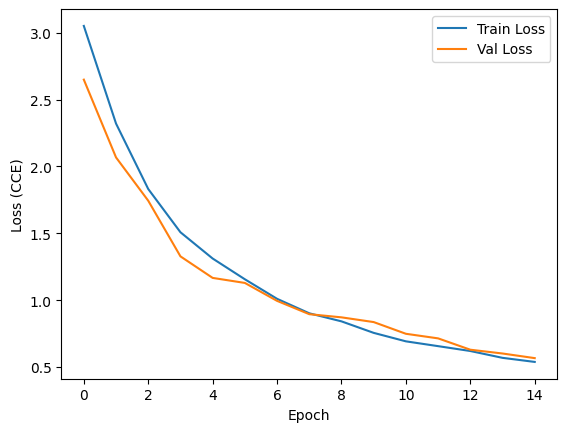

In [ ]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses  , label='Val Loss')

plt.ylabel('Loss (CCE)')
plt.xlabel('Epoch')

plt.legend()
plt.show()

## Play with the model to reach a better accuarcy.